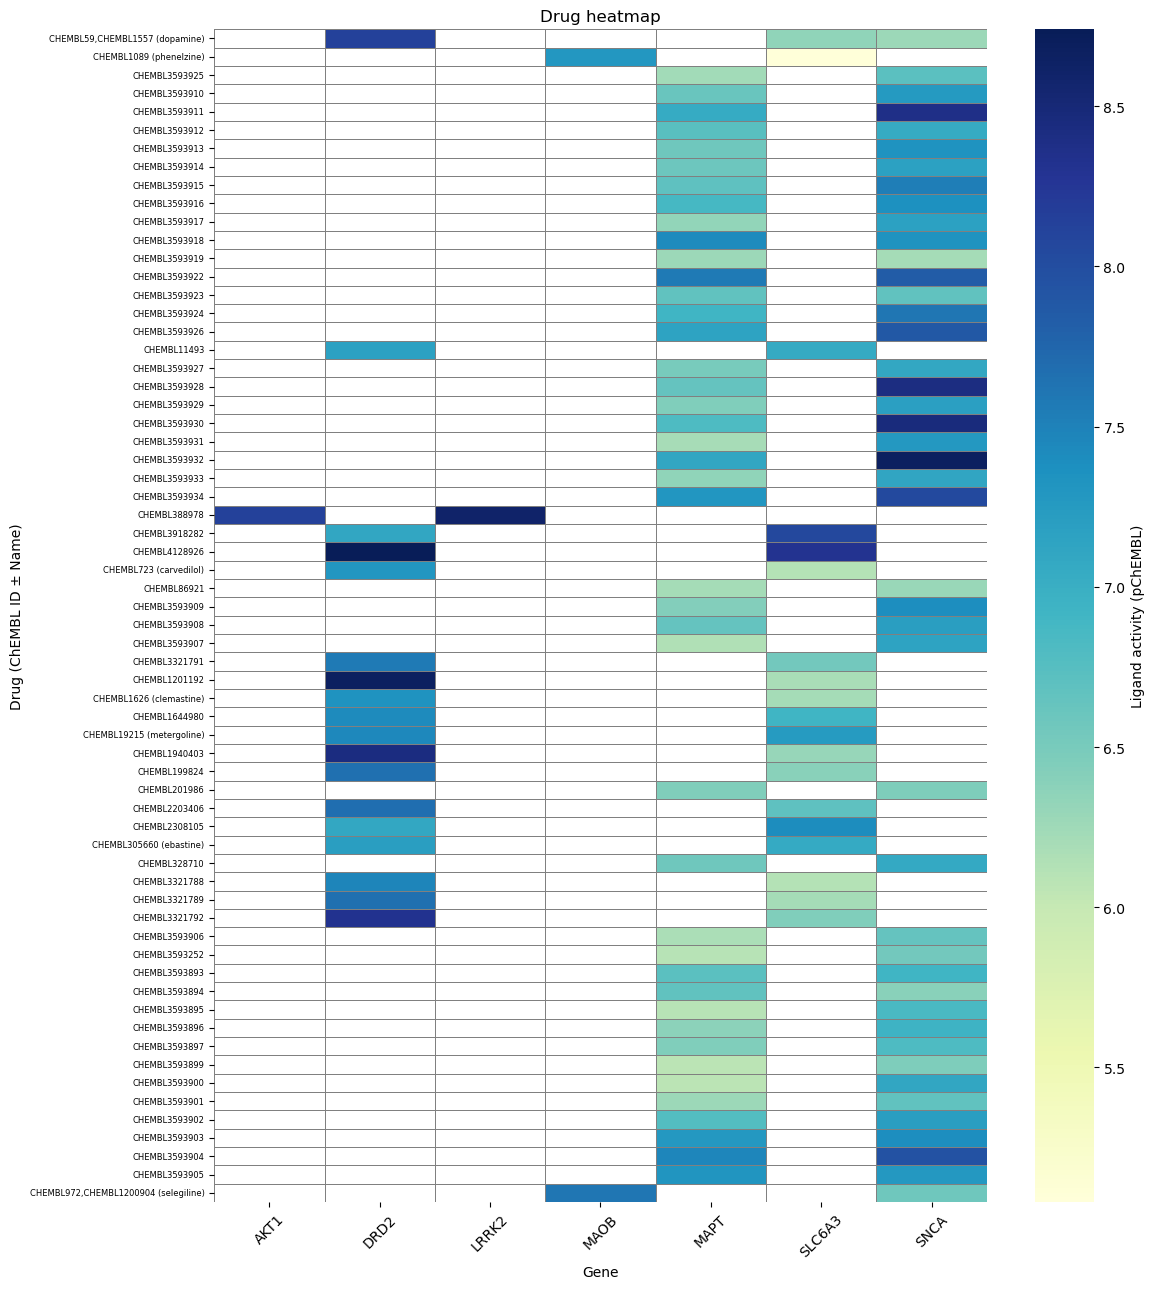

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("query results.csv")

# Clean and convert necessary columns
df = df.dropna(subset=["Ligand ChEMBL ID", "Symbol", "Ligand Activity"])
df["Ligand ChEMBL ID"] = df["Ligand ChEMBL ID"].astype(str).str.strip()
df["Symbol"] = df["Symbol"].astype(str).str.strip()
df["Ligand Activity"] = pd.to_numeric(df["Ligand Activity"], errors="coerce")
df["Ligand Is Drug"] = pd.to_numeric(df["Ligand Is Drug"], errors="coerce").fillna(0).astype(int)
df["Ligand Name"] = df["Ligand Name"].astype(str).fillna("").str.strip()

# Create drug label: name only shown if marked as drug
def label_with_name(row):
    if row["Ligand Is Drug"] == 1 and row["Ligand Name"]:
        return f"{row['Ligand ChEMBL ID']} ({row['Ligand Name']})"
    return row["Ligand ChEMBL ID"]

df["DrugLabel"] = df.apply(label_with_name, axis=1)

# Keep only drugs shared by ≥2 genes
shared = df.groupby("DrugLabel")["Symbol"].nunique()
shared_drugs = shared[shared >= 2].index
df = df[df["DrugLabel"].isin(shared_drugs)]

# Pivot table: average ligand activity per gene per drug
pivot = df.groupby(["DrugLabel", "Symbol"])["Ligand Activity"].mean().unstack()

# Sort rows by number of gene associations
pivot["HitCount"] = pivot.notna().sum(axis=1)
pivot = pivot.sort_values("HitCount", ascending=False).drop(columns="HitCount")

# Plot
plt.figure(figsize=(12, 13))
sns.heatmap(pivot, cmap="YlGnBu", annot=False, linewidths=0.5, linecolor='gray', cbar_kws={"label": "Ligand activity (pChEMBL)"})
plt.title("Drug heatmap")
plt.xlabel("Gene")
plt.ylabel("Drug (ChEMBL ID ± Name)")
plt.xticks(rotation=45)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()
